# Thermal Occupations Redux
## Non-Interacting only
### By Anthony Osborne
#### Based on code from Vincent Martinetto

In [1]:
%matplotlib inline

In [56]:
import numpy as np
import scipy.sparse as spa
from scipy.sparse.linalg import eigsh
from numpy import linspace
from numpy import array
import matplotlib.pyplot as plt
from scipy.integrate import simps
import matplotlib.animation as animation
from IPython.display import HTML
import iDEA
import math
from matplotlib import cm
import scipy
from decimal import Decimal

## Set up
### Definition of Harmonic Oscillator $v_{ext}$ and Fermi Occupation Function

In [3]:
# Fermi Occupation function
def occs(Eis,mu,tau):
    '''
    INPUT:
        tau: Scalar
            the tau value to find the temprature dependent mu for
        mus: scalar
            a guess at a value below the chemical potential for tau
        Eis: Scalar
            Some kind of energy -- AO
    OUTPUT
        F_occs: Scalar
            The Fermi Occupation for mu, tau, Eis
    '''
    F_occs = 1/(1+np.exp((Eis-mu)/tau))
    return F_occs

#Harmonic oscillator external potential
def v_harm(x):
    '''
    INPUT:
        x: ndarray
            Position
    OUTPUT
        harm_ext: Scalar
            harmonic oscillator potential
    '''
    harm_ext = .5*x**2
    return harm_ext

### Plotting Function

In [45]:
def plotFunction(Function, a, b, Ngrid, N="None", eigenValues="None",eigenVaectors="None", x_lim1=0, x_lim2=10, y_lim1=-1, y_lim2=10, xlabel="", ylabel="", title="", ncols=1, thickGraph="no", plotPoint="no", px=0, pfx=0):
        """
        Description: Plot function for notebook
        Current Capabilites: Built to test different functions to make sure they are working as expected 
        Goal: Eventually this will be set up to plot everything in the notebook 
        Note: To adjust the plot you can use matplotlib functions before this function call. Example:
            plt.title("A plot")
            plt.ylim(0,5)
            plt.xlim(-1,2)
            plotFunction(lambda x: x**2, a, b, ...)

        :param potentialfunction: V(x)
        :param a: left interval
        :param b: right interval
        :param x_lim1: The left x axis limit            default: 0
        :param x_lim2: The right x axis limit           default: 10
        :param y_lim1: The bottom y axis limit          default: -1 
        :param y_lim1: The top y axis limit             default: 10
        :param xlabel: Label for x axis                 default: blank
        :param ylabel: Label for y axis                 default: blank
        :param title:  Title for plot                   default: blank
        :param nocls: the number of columns for figure  default: 1 Currenlty only works for 1 column needs updating for >1
        :param thickGraph: determines axes thickness    default: no Ideal for code. For posters use yes
        #-------> Not used in current build but here for the future use
        :param N: Number of basis functions
        :param eigenValues: Eigenvalues
        :param eigenVectors: Eigenvector matrix of size N x len(eigenValues)
        """
        if ncols >1:
                print("Error Function is currently built to handle only one column")
                print("Quitting Plot Function. Please adjust parameters and try again")

                return 
        x = linspace(a,b,Ngrid)
        #---------------> Plot
        fig, ax = plt.subplots(ncols, dpi=100) #sharex=True, sharey=True, dpi=200)
        #---------------> Data
        ax.plot(x, Function(x), linewidth=1,)
        if thickGraph =="y":
                ax.plot(x, Function(x), linewidth=3,)
        if plotPoint =="y":
                ax.plot(px, pfx, 'bo')
                #ax.annotate(px, pfx)
        #---------------> Formatting
        ax.set_ylim(y_lim1, y_lim2)
        ax.set_xlim(x_lim1, x_lim2)

        #ax.set(adjustable='box', aspect='equal')
        ax.set_xlabel(xlabel, fontsize=20)
        ax.set_ylabel(ylabel, fontsize=20)
        fig.suptitle(title, fontsize=20)
        fig.tight_layout()
        #-------> Borders ## Have to run cell twice for this to work no idea why -- AO
        if thickGraph == "y":
                plt.rcParams["axes.edgecolor"] = "black"
                plt.rcParams["axes.linewidth"] = 2.0
                plt.xticks(fontsize=15)
                plt.yticks(fontsize=15)
                ax.xaxis.set_tick_params(width=2)
                ax.yaxis.set_tick_params(width=2)

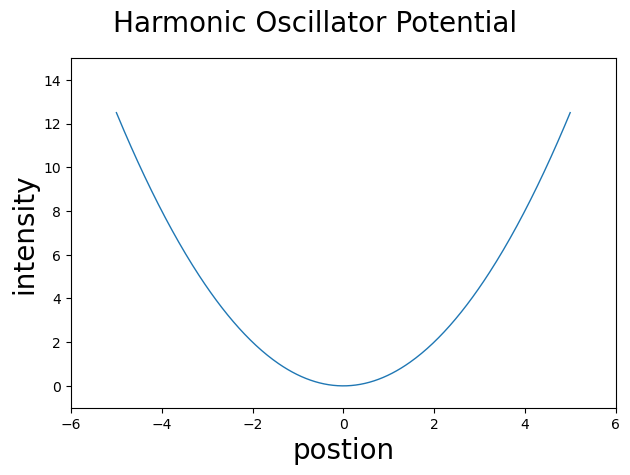

In [46]:
plotFunction(v_harm, -5, 5, 401, x_lim1=-6, x_lim2=6, y_lim1=-1, y_lim2=15, xlabel="postion", ylabel="intensity" ,title="Harmonic Oscillator Potential", ncols=1)


### Secant method for root finding

In [26]:
def secant(x0,x1,fx0,fx1):
    '''
    the update process for the secant method
    '''
    return (x0*fx1-fx0*x1)/(fx1-fx0)

def secant_method(x0,x1,func,criterion=1e-6,max_iter=100):
    '''
    Description: Based on the secant method page on wikipedia
    takes the first two guesses at the correct root and a defined
    function then run the secant method to find the root.
    INPUT:
        x0: Scalar
            First guess at root value
        x1: scalar
            Second guess at root value
        func: Scalar
            Function to find root of
    OUTPUT
        x1: Scalar
            Root value
        fx1: Scalar
            function evaluated at root value            
    '''
    
    i = 0
    
    fx0 = func(x0)
    fx1 = func(x1)
    conv = abs(min([fx0,fx1]))
    
    while conv > criterion:
        xt = secant(x0,x1,fx0,fx1)
        
        fx0 = fx1
        x0 = x1
        x1 = xt
        fx1 = func(x1)
        
        conv = abs(fx1)
        
        if i > max_iter:
            break
        i += 1
        
    return x1,fx1

#### Secant Method test

Point coordinates are: -1.7080391071060965e-07 , -1.7080391071060798e-07


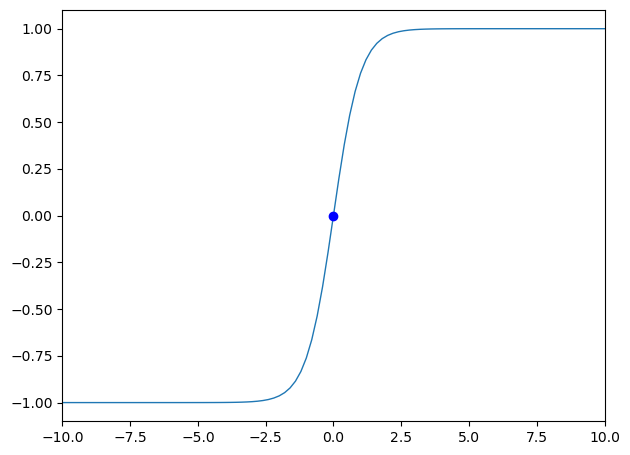

In [42]:
x0,fx0 = secant_method(-2.5,3,np.tanh)
print("Point coordinates are:", x0,",", fx0)
plotFunction(np.tanh, -10, 10, 101, y_lim1=-1.1, y_lim2=1.1, x_lim1=-10, x_lim2=10, plotPoint="y", px=x0, pfx=fx0 )

### Calculating Harmonic Oscillator or P.I.B. Eigenstates and Eigenvectors

In [79]:
def Eigen_Solver(Sys, a, b, Nx, nk):
    '''
    Description: Solves for the eigenvalues and eigenvectors of either the H.O. or P.I.B.
    Current Capabilities: Does all that it is desired
    Goal: 
    Note: Need to define nk, pretty sure all values are correct
    INPUT:
        Sys: String
            Determines if using Harmonic Oscillator or P.I.B. 
        a: Scalar
            Left limit of linespace
        b: scalar
            Right limit of linespace
        Nx: scalar
            Number of points in linespace
        nk: scalar
            Number of kpoints??? Not sure what this is
    OUTPUT
        x1: Scalar
            Root value
        fx1: Scalar
            function evaluated at root value            
    '''
    #-------> Set-Up
    x = linspace(a, b, Nx)
    if Sys == "Harm":
        v_ext = v_harm(x)
    if Sys == "PIB":
        v_ext = np.zeros(Nx)
    #-------> Diagonalization 
    dx = x[1]-x[0]
    diag = (np.ones(Nx)/dx**2)
    #print(diag)
    diags = array([(v_ext+diag), (diag/2), (diag/2)])
    #-------> Calculating Hamiltonian
    H = spa.dia_matrix((diags,[0,-1,1]),shape=(Nx,Nx))
    vals, vecs = eigsh(H,which='SA',k=nk)
    vec_sum = np.trapz(vecs[:,0]**2,x)
    norm = np.sqrt(1/vec_sum)
    vecs = vecs*norm
    return vals, vecs

#### Solver Function test

In [80]:
a, b, Nx, nk = -5, 5, 401, 100
vals, vecs = Eigen_Solver("Harm", a, b, Nx, nk)
#print(vals)
#print(vecs)